In [ ]:
rom google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Loading the tokenizer
tokenizer = BartTokenizer.from_pretrained('/content/drive/MyDrive/bart_tokenizer')

# Loading the model
model = BartForConditionalGeneration.from_pretrained('/content/drive/MyDrive/bart_model')

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [ ]:
import pandas as pd

# Load the file
file_path = '/content/drive/MyDrive/Colab Notebooks/updated_text_analysis.csv'
data = pd.read_csv(file_path)

In [ ]:
# Sample 20,000 records from the dataset
sampled_data = data.sample(n=100, random_state=42)

In [ ]:
# Select the 'document' column
documents = sampled_data['document'].dropna().tolist()                           # Dropping any NaN values if present

In [ ]:
def generate_summary(text):
    try:
        # Tokenize the input with truncation to handle long text
        inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

        # Generate the summary with controlled parameters
        summary_ids = model.generate(
            inputs['input_ids'],
            max_length=150,
            min_length=40,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )

        # Decode and return the summary text
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    except Exception as e:
        print(f"Error generating summary for text: {text[:100]}...")             # Print a snippet of the text
        print(f"Error message: {e}")
        return None

In [ ]:
from tqdm import tqdm

# Initialize an empty list to store summaries
all_summaries = []

# Define batch size
batch_size = 10

# Process documents in batches with a progress bar
for i in tqdm(range(0, len(documents), batch_size), desc="Processing batches"):
    # Get the current batch of documents
    batch = documents[i:i + batch_size]

    # Generate summaries for the batch
    batch_summaries = [generate_summary(text) for text in batch]

    # Append the batch summaries to the main list
    all_summaries.extend(batch_summaries)

# Add the summaries to the DataFrame
sampled_data['predicted_summary'] = all_summaries

Processing batches: 100%|██████████| 10/10 [40:47<00:00, 244.73s/it]


In [ ]:
# Save the results to a new CSV file in Google Drive
output_path = '/content/drive/MyDrive/dataset_with_summaries.csv'
sampled_data.to_csv(output_path, index=False)

print("Summaries saved successfully.")

Summaries saved successfully.


In [ ]:
pip install rake_nltk

In [ ]:
import pandas as pd
from rake_nltk import Rake
import nltk

# Load the file
file_path = '/content/drive/MyDrive/dataset_with_summaries.csv'
sampled_data = pd.read_csv(file_path)

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

sampled_data['predicted_summary'] = sampled_data['predicted_summary'].fillna("")
sampled_data['predicted_summary'] = sampled_data['predicted_summary'].astype(str)

# Initialize RAKE
rake = Rake()

# Function to extract keywords
def extract_top_keywords(text):
    rake.extract_keywords_from_text(text)                                        # Extract keywords from the text
    ranked_phrases = rake.get_ranked_phrases()                                   # Get keywords without scores
    return ranked_phrases[:3]                                                    # Return top 3 keywords

# Step 5: Apply RAKE to the 'document' column
sampled_data['top_keywords'] = sampled_data['predicted_summary'].apply(extract_top_keywords)

# Display the first few rows with the top keywords
sampled_data[['document', 'predicted_summary', 'top_keywords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,document,predicted_summary,top_keywords
0,just create a second mode for expeditions that...,for expeditions and have fun with the mods / ...,"[different way, different way, weapons]"
1,hi there ! i am a software developer for nearl...,for someone who wants to be a software develo...,"[software developer, religious war, comment se..."
2,these recently touched down in my area and i m...,. don't buy them and don't use flavorz carts. ...,"[use flavorz carts, x200b, x200b]"
3,my dad m44 has been diagnosed with a serious i...,. my sibs steals objects that are sentimental ...,"[sibs steals objects, steal, sentimental]"
4,long story - in 2019 i got a bit too big for m...,,[]


In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   document            100 non-null    object
 1   summary             100 non-null    object
 2   id                  100 non-null    object
 3   rg_labels           100 non-null    object
 4   ext_labels          100 non-null    object
 5   document_sentiment  100 non-null    object
 6   summary_sentiment   100 non-null    object
 7   document_token      100 non-null    object
 8   summary_token       100 non-null    object
 9   document_topics     100 non-null    object
 10  summary_topics      100 non-null    object
 11  predicted_summary   100 non-null    object
 12  top_keywords        100 non-null    object
dtypes: object(13)
memory usage: 10.3+ KB


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess the documents
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stop words
    words = [word for word in text.split() if word not in stop_words]
    # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to each document
cleaned_data = [preprocess_text(doc) for doc in sampled_data['document']]

# Convert the cleaned documents into a bag-of-words model
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(cleaned_data)

# Fit the LDA model
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(doc_term_matrix)

# Display the topics and their top words
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print("\n")

# Assign topic labels to each document
sampled_data['topic_label'] = lda.transform(doc_term_matrix).argmax(axis=1)

no_top_words = 10  # Number of words to display per topic

# Extract topic words
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    topic_words.append(" ".join(top_words))

# Save the topic words in a new column by mapping topic labels to topic words
sampled_data['topic_words'] = sampled_data['topic_label'].map(lambda x: topic_words[x])

# Display the DataFrame with original text, topic label, and topic words
sampled_data[['document', 'topic_label', 'topic_words']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,document,topic_label,topic_words
0,just create a second mode for expeditions that...,0,nt like work know think dragon make want got need
1,hi there ! i am a software developer for nearl...,0,nt like work know think dragon make want got need
2,these recently touched down in my area and i m...,3,nt like day really know got year lot time ive
3,my dad m44 has been diagnosed with a serious i...,1,nt like time thing feel friend want know reall...
4,long story - in 2019 i got a bit too big for m...,3,nt like day really know got year lot time ive
...,...,...,...
95,"my gf is taking birth control , and the effect...",1,nt like time thing feel friend want know reall...
96,how stupid i can be sometimes . so me and my g...,1,nt like time thing feel friend want know reall...
97,my friend sent me a post about trans rights an...,0,nt like work know think dragon make want got need
98,it happened in a russian prison . in a penal c...,3,nt like day really know got year lot time ive


In [ ]:
# Get the count of each topic
topic_counts = sampled_data['topic_label'].value_counts()

# Display the topic counts
print(topic_counts)

topic_label
1    41
0    25
3    24
2    10
Name: count, dtype: int64


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment_score(text):
    # Get the sentiment score for the text
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Compound score is a general sentiment indicator

# Calculate sentiment scores for the columns
sampled_data['document_sentiment'] = sampled_data['document'].apply(get_sentiment_score)
sampled_data['summary_sentiment'] = sampled_data['summary'].apply(get_sentiment_score)
sampled_data['predicted_summary_sentiment'] = sampled_data['predicted_summary'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


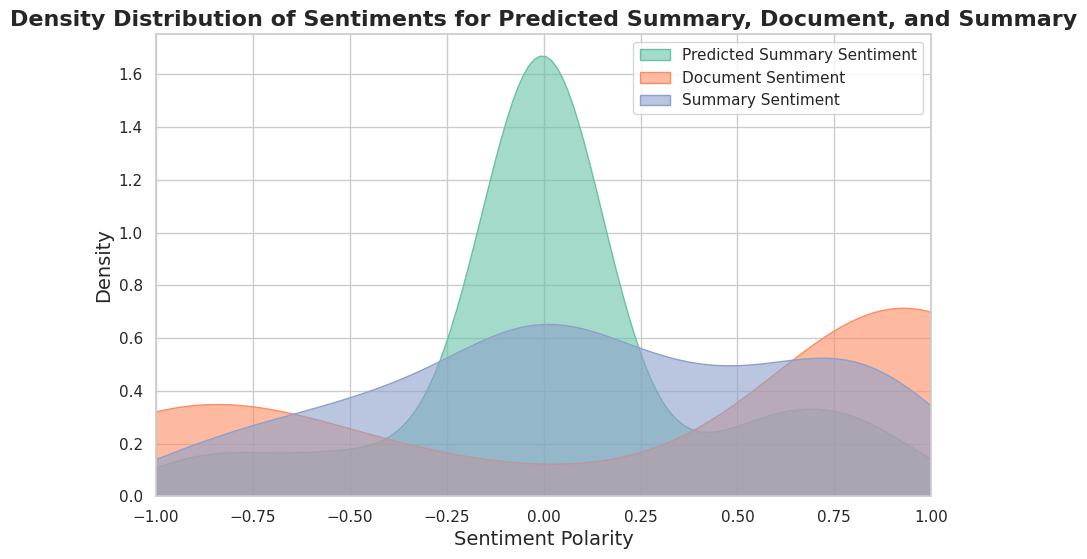

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style for a clean look
sns.set(style="whitegrid")

# Custom color palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Melting the DataFrame for use in seaborn
melted_data = sampled_data.melt(value_vars=['predicted_summary_sentiment', 'document_sentiment', 'summary_sentiment'],
                                var_name='Type', value_name='Sentiment')

# Creating a figure
plt.figure(figsize=(10, 6))

# KDE plot for density distribution
sns.kdeplot(data=melted_data[melted_data['Type'] == 'predicted_summary_sentiment'],
            x='Sentiment', color=colors[0], fill=True, label='Predicted Summary Sentiment', alpha=0.6)
sns.kdeplot(data=melted_data[melted_data['Type'] == 'document_sentiment'],
            x='Sentiment', color=colors[1], fill=True, label='Document Sentiment', alpha=0.6)
sns.kdeplot(data=melted_data[melted_data['Type'] == 'summary_sentiment'],
            x='Sentiment', color=colors[2], fill=True, label='Summary Sentiment', alpha=0.6)

# Title and labels with custom font sizes
plt.title('Density Distribution of Sentiments for Predicted Summary, Document, and Summary',
          fontsize=16, weight='bold')
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Adding legend
plt.legend()

# Adjusting x-axis limits for better visualization
plt.xlim(-1, 1)

# Displaying the plot
plt.show()